In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import matplotlib.pyplot as plt
from transformers import *
%matplotlib inline

In [3]:
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased')]

# To use TensorFlow 2.0 versions of the models, simply prefix the class names with 'TF', e.g. `TFRobertaModel` is the TF 2.0 counterpart of the PyTorch model `RobertaModel`

# Let's encode some text in a sequence of hidden-states using each model:
for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    # Encode text
    input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

## Tokenizer exploration

In [4]:
def token_exploration (x, add_special_tokens=False):
    tok = tokenizer.encode(x, add_special_tokens=add_special_tokens)
    print(x, "  ", tokenizer.tokenize(x), "  ", tok, ",  mida:", len(tok))
    return tok
token_exploration("Here I am", add_special_tokens=True)
token_exploration("Here I am")
token_exploration("Greetings I am")
token_exploration("Hola")
token_exploration("Moi")
token_exploration("ester")
token_exploration("esterno")
token_exploration("esternocli")
token_exploration("esternoclido")
token_exploration("esternoclidomas")
token_exploration("esternoclidomastoidal")
token_exploration("esternoclidomastoidalewq")
token_exploration("create")
token_exploration("created")
token_exploration("create d")
token_exploration("mas")
token_exploration("más")
token_exploration("másede")
token_exploration("ede")
token_exploration("masto")
token_exploration("mastodont")
token_exploration("mastodonts")
token_exploration("mastodonte")
token_exploration("mastodontes")
token_exploration("specialise")
token_exploration("specialize")
token_exploration("length")
token_exploration("lenght")
token_exploration(".")
token_exploration("més.mes")
token_exploration("un")
token_exploration("do")
token_exploration("undo")
token_exploration("[CLS]")
token_exploration("[SEP]")
token_exploration("[PAD]")

Here I am    ['here', 'i', 'am']    [101, 2182, 1045, 2572, 102] ,  mida: 5
Here I am    ['here', 'i', 'am']    [2182, 1045, 2572] ,  mida: 3
Greetings I am    ['greeting', '##s', 'i', 'am']    [14806, 2015, 1045, 2572] ,  mida: 4
Hola    ['ho', '##la']    [7570, 2721] ,  mida: 2
Moi    ['moi']    [25175] ,  mida: 1
ester    ['este', '##r']    [28517, 2099] ,  mida: 2
esterno    ['este', '##rno']    [28517, 19139] ,  mida: 2
esternocli    ['este', '##rno', '##cl', '##i']    [28517, 19139, 20464, 2072] ,  mida: 4
esternoclido    ['este', '##rno', '##cl', '##ido']    [28517, 19139, 20464, 13820] ,  mida: 4
esternoclidomas    ['este', '##rno', '##cl', '##ido', '##mas']    [28517, 19139, 20464, 13820, 9335] ,  mida: 5
esternoclidomastoidal    ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal']    [28517, 19139, 20464, 13820, 9335, 3406, 16975] ,  mida: 7
esternoclidomastoidalewq    ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal', '##ew', '##q']    [28517, 19139, 2046

[0]

Some conclusions:
* The end of the sequence is not marked
* Signs have an embedding
* If we pick a word and add some letters (and the new word makes no sense), the embedding will be lengthened. The original part will remain the same. The new part is not the same as if it is studied alone
* Accents are not taken into consideration
* It does not correct errors and words such as "specialise" and "specialize" are embedded differently

In [6]:
# Data Information
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
# Train Dataset

# id: rowID
# qid{1, 2}: unique ID of each question in the pair
# question{1, 2}: textual contents of the questions.
# is_duplicate: target, whether the two questions are duplicates of each other.

#df_train = pd.read_csv("../input/quora-question-pairs/train.csv.zip").fillna("")
df_train = pd.read_csv("data/train.csv").fillna("")
df_train.head()

df_test = pd.read_csv("data/test.csv").fillna("")

/home/xavier/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
print('Total of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))

Total of question pairs for training: 404290
Duplicate pairs: 36.92%


## **Question study**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb


### **Unique questions:**

Text(0, 0.5, 'Number of questions')

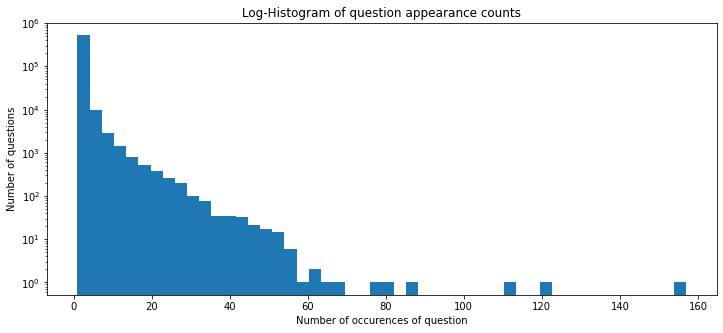

In [11]:
tr_qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
dic = tr_qids.value_counts()
plt.figure(figsize=(12, 5))
plt.hist(dic, bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

In [33]:
print("Number of unique questions: ", len(dic), ".  Number of questions: ", len(tr_qids), ".  Ratio: ", 100*len(dic)/len(tr_qids), '%', sep="")

Number of unique questions: 537933.  Number of questions: 808580.  Ratio: 66.52811100942392%


### **Question equivalence:**

In [13]:
def clusters(llista):
    class_to_nodes = {}
    node_to_class = {}
    for f,s,t in llista:
        #print("-----------------------")
        #print("class_to_nodes")
        #print(class_to_nodes)
        #print("node_to_class")
        #print(node_to_class)
        if t:
            if not f in node_to_class:
                node_to_class[f] = f
                class_f = f
            else:
                aux = f
                while aux != node_to_class[aux]:
                    aux = node_to_class[aux]
                class_f = aux

            if not s in node_to_class:
                node_to_class[s] = s
                class_s = s
            else:
                aux = s
                while aux != node_to_class[aux]:
                    aux = node_to_class[aux]
                class_s = aux
            #print("classes: ", class_f, class_s)

            class_m = min(class_f, class_s)
            class_M  = max(class_f, class_s)
            if not class_m in class_to_nodes:
                class_to_nodes[class_m] = [class_m]
            if not class_M in class_to_nodes:
                class_to_nodes[class_M] = [class_M]

            class_to_nodes[class_m] += class_to_nodes[class_M]
            for el in class_to_nodes[class_M]:
                node_to_class[el] = class_m
            del class_to_nodes[class_M]
    return (class_to_nodes, node_to_class)

In [31]:
(class_to_nodes, node_to_class) = clusters(np.array(df_train[["qid1", "qid2","is_duplicate"]]))
print("There are", len(class_to_nodes), "different question classes")

There are 51071 different question classes


In [32]:
sizes = [0]*9
for cl in class_to_nodes:
    sizes[len(class_to_nodes[cl])] += 1
assert np.sum(sizes) == len(class_to_nodes)
sizes

[0, 0, 48469, 2245, 289, 51, 13, 3, 1]

### **Sentence length:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

Text(0, 0.5, 'Probability')

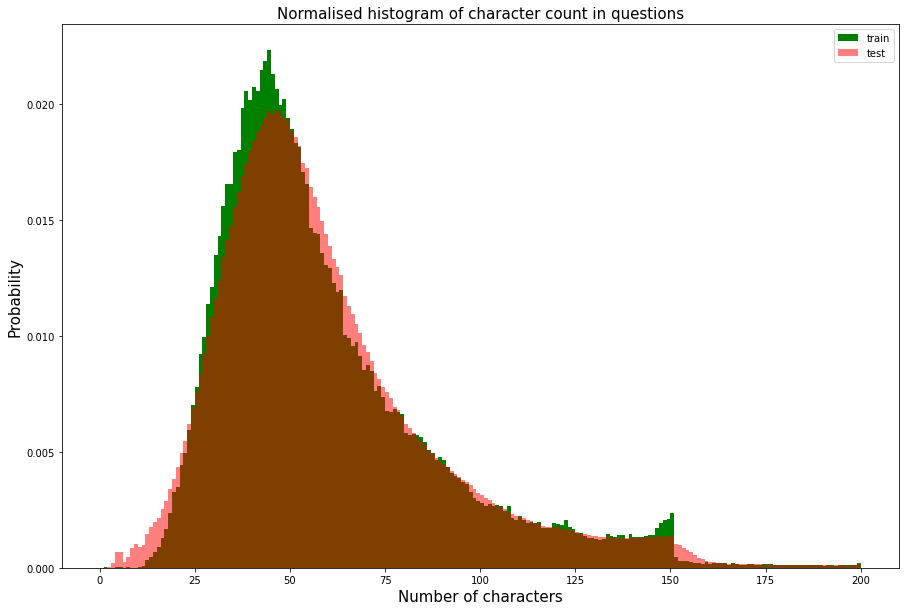

In [120]:
qs_tr = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
qs_te = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

cc_train = qs_tr.apply(len)
cc_test = qs_te.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(cc_train, bins=200, range=[0, 200], color="green", density=True, label='train')
plt.hist(cc_test, bins=200, range=[0, 200], color="red", density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## **Word study**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [36]:
chs = [".", ":", ",", ";", "¿", "?", "¡", "!", "(", ")"]

In [117]:
words = {}
for s in range(len(qs_tr)):
    for ch in chs:
        qs_tr[s] = qs_tr[s].replace(ch, "")
    for w in qs_tr[s].split(' '):
        words[w] = words.get(w,0) + 1

In [39]:
prova = ["h.erers r,fasf (dfsa) ;i,:o", "h.erers r,fasf (dfsa) ;i,:o"]
for i in range(len(prova)):
    for ch in chs:
        prova[i] = prova[i].replace(ch, "")
print(prova)

['herers rfasf dfsa io', 'herers rfasf dfsa io']


In [52]:
prova = ["ac"]
if "ac" in prova:
    print("hey")

hey


In [118]:
'''
for x in sorted(words):
    print(x, words[w])
words = sorted(words)
'''
[(key, value) for (key, value) in sorted(words.items())]

[('', 7019),
 ('\n1', 2),
 ('"', 315),
 ('""', 48),
 ('""Barbarians', 1),
 ('""I', 1),
 ('""YOU""', 3),
 ('""programming', 1),
 ('""safely""', 1),
 ('""scripting', 1),
 ('"#', 1),
 ('"#"', 2),
 ('"#define', 1),
 ('"#goals"', 1),
 ('"$"', 2),
 ('"$$"', 1),
 ('"$1', 1),
 ('"%"', 1),
 ('"%20"', 1),
 ('"%4d"', 2),
 ('"%c"', 2),
 ('"%d', 6),
 ('"%d"', 3),
 ('"%d\\n"', 1),
 ('"%s"', 2),
 ('"&"', 23),
 ('"*"', 1),
 ('"+"', 6),
 ('"-"', 3),
 ('"-2', 1),
 ('"->"', 2),
 ('"-desu"', 1),
 ('"-ee"', 1),
 ('"-nib"', 1),
 ('"-or"', 1),
 ('"-s"', 1),
 ('"-ture"', 1),
 ('"-wise"', 1),
 ('"/"', 1),
 ('"0002"', 1),
 ('"000V"', 1),
 ('"1', 1),
 ('"1"', 4),
 ('"1%ers"', 1),
 ('"1+1=3"', 1),
 ('"1-dimensional', 1),
 ('"10', 3),
 ('"10-58"', 1),
 ('"10-81"', 1),
 ('"100', 2),
 ('"100+"', 1),
 ('"108"', 1),
 ('"10X"', 1),
 ('"10th', 3),
 ('"12', 2),
 ('"12"', 1),
 ('"13', 1),
 ('"1337"', 1),
 ('"15', 1),
 ('"17', 1),
 ('"1984"', 8),
 ('"1m"', 1),
 ('"2', 3),
 ('"2+2"', 1),
 ('"20', 6),
 ('"20"', 1),
 ('"20/13

In [87]:
print(sorted(words.items())[8])
print(qs_tr[0])

('""', 290)
What is the step by step guide to invest in share market in india


In [ ]:
prova = pd.Series(["ab ab ac bc", "ab ab", "ab"])
prova.apply(lambda x: len(x.split(' ')))

In [7]:
a = "azzbzzczz"
a = a[1:]
a

'zzbzzczz'

In [ ]:
def normalizar(d):
    for string in d.keys(): 
        for char in string:
            d[string] = unidecode.unidecode(d[string])
            d[string]= d[string].lower()
            d[string] = d[string].replace(" ", "")
            if char in "+":
                string = string.replace(char,'')
            for char in d[string]:
                if char in "+":
                    d[string] = d[string].replace(char,'')

    return d

Text(0, 0.5, 'Probability')

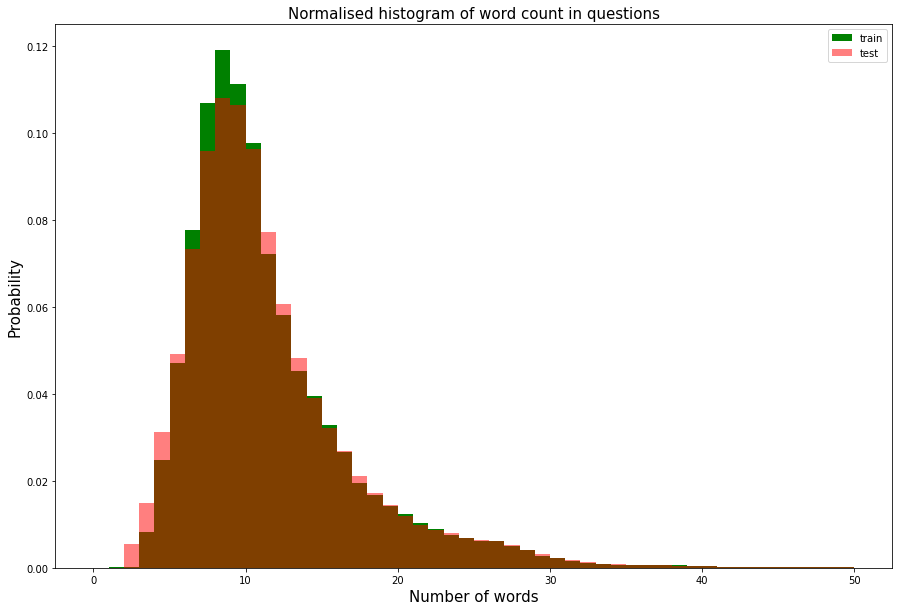

In [121]:
wc_train = qs_tr.apply(lambda x: len(x.split(' ')))
wc_test = qs_te.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(wc_train, bins=50, range=[0, 50], color="green", density=True, label='train')
plt.hist(wc_test, bins=50, range=[0, 50], color="red", density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [135]:
min(wc_train)

1

### **Word Cloud:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(qs_tr.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## **Semantic study**

In [ ]:
qmarks = np.mean(qs_tr.apply(lambda x: '?' in x))
math = np.mean(qs_tr.apply(lambda x: '[math]' in x))
fullstop = np.mean(qs_tr.apply(lambda x: '.' in x))
capital_first = np.mean(qs_tr.apply(lambda x: x[0].isupper()))
capitals = np.mean(qs_tr.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(qs_tr.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

In [ ]:
print(tokenizer.tokenize("Hola"))